In [426]:
import dlc_practical_prologue as plg
from torch import nn
from torch.nn import functional as F
import torch
from operator import mul as multiplicator
from functools import reduce

if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = plg.generate_pair_sets(N)
train_input = train_input.to(device)
train_target = train_target.to(device)
train_classes = train_classes.to(device)
test_input = test_input.to(device)
test_target = test_target.to(device)
test_classes = test_classes.to(device)


#train_input, train_classes, train_target = augment(train_input, train_classes, train_target, 4)

# Normalization
mu, std = train_input.mean(), train_input.std()
train_input = train_input.sub(mu).div(std)
test_input = test_input.sub(mu).div(std)



In [211]:
def augment(train_input, train_classes, train_target, n):
    output_samples = train_input
    output_classes = train_classes
    output_targets = train_target
    
    batch_size = train_input.shape[0]
    for i in range(n):
        left_random_ind = (torch.rand((batch_size,)) * batch_size).long()
        right_random_ind = (torch.rand((batch_size,)) * batch_size).long()
        
        left_random = train_input[left_random_ind,0,:,:].view(batch_size, 1, 14, 14)
        right_random = train_input[right_random_ind,1,:,:].view(batch_size, 1, 14, 14)
        
        new_train = torch.cat((left_random, right_random), 1)
        new_class = torch.cat((train_classes[left_random_ind,0].view(-1,1),train_classes[right_random_ind,1].view(-1,1)),1)
        new_target = (train_classes[left_random_ind, 0] < train_classes[right_random_ind, 1]).long()
        
        
        output_samples = torch.cat((output_samples, new_train), 0)
        output_classes = torch.cat((output_classes, new_class), 0)
        output_targets = torch.cat((output_targets, new_target), 0)
        
    return output_samples, output_classes, output_targets

In [115]:
class SiameseNet(nn.Module):
    def __init__(self, chan1 = 16, chan2 = 32, chan3 = 64, nb_hidden1 = 100, nb_hidden2 = 50, nb_hidden3 = 50, nb_hidden4 = 10):
        super(SiameseNet, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("conv_1", nn.Conv2d(1, chan1, kernel_size=3))
        self.features.add_module("relu_1", nn.ReLU())
        self.features.add_module("maxpool_1", nn.MaxPool2d(kernel_size=2))
        self.features.add_module("conv_2", nn.Conv2d(chan1, chan2, kernel_size=2))
        self.features.add_module("relu_2", nn.ReLU())
        self.features.add_module("maxpool2", nn.MaxPool2d(kernel_size=2, dilation=1))
        self.features.add_module("conv_3", nn.Conv2d(chan2, chan3, kernel_size=2))
        self.features.add_module("relu_3", nn.ReLU())
        
        class_size = self.features(torch.empty((1, 1, 14, 14))).shape
        self.linear_size = reduce(multiplicator, list(class_size[1:]))
        
        self.classifier1 = nn.Sequential()
        self.classifier1.add_module("linear_1", nn.Linear(self.linear_size, nb_hidden1))
        self.classifier1.add_module("relu_1", nn.ReLU())
        self.classifier1.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier1.add_module("linear_2", nn.Linear(nb_hidden1, nb_hidden2))
        self.classifier1.add_module("relu_2", nn.ReLU())
        self.classifier1.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier1.add_module("linear_3", nn.Linear(nb_hidden2, 10))
        
        self.classifier2 = nn.Sequential()
        self.classifier2.add_module("linear_1", nn.Linear(10, nb_hidden3))
        self.classifier2.add_module("relu_1", nn.ReLU())
        self.classifier2.add_module("dropout_1", nn.Dropout(0.25))
        self.classifier2.add_module("linear_2", nn.Linear(nb_hidden3, nb_hidden4))
        self.classifier2.add_module("relu_2", nn.ReLU())
        self.classifier2.add_module("dropout_2", nn.Dropout(0.25))
        self.classifier2.add_module("linear_3", nn.Linear(nb_hidden4, 2))
        

    def forward(self, x):
        out_aux = []
        for i in range(0, 2):
            x_i = x[:,i,:,:].view((x.shape[0], 1) + tuple(x.shape[2:]))
            x_i = self.features(x_i)
            out_aux.append(self.classifier1(x_i.view(-1, self.linear_size)))
        diff = out_aux[1] - out_aux[0]
        #diff = torch.cat((out_aux[1], out_aux[0]), 1)
        out = self.classifier2(diff)
        return out, out_aux

In [116]:
# Check on the sizes
X = torch.empty((1, 1, 14, 14)).normal_()
net = SiameseNet()
for layer in net.features:
    if isinstance(layer, nn.Linear):
        X = X.view(-1, reduce(multiplicator, list(X.shape[1:])))
    X = layer(X)
    print(layer, 'output shape:\t', X.shape)

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)) output shape:	 torch.Size([1, 16, 12, 12])
ReLU() output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 16, 6, 6])
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 32, 5, 5])
ReLU() output shape:	 torch.Size([1, 32, 5, 5])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) output shape:	 torch.Size([1, 32, 2, 2])
Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1)) output shape:	 torch.Size([1, 64, 1, 1])
ReLU() output shape:	 torch.Size([1, 64, 1, 1])


In [451]:
def train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False, n=0):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)

    train_input, train_classes, train_target = augment(train_input, train_classes, train_target, n)
    train_input.sub_(train_input.mean()).div_(train_input.std())
    for e in range(0, epochs):
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [450]:
def train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="SGD", momentum = 0, nesterov = False, n=0):
    
    if (optim == "SGD"):
        optimizer = torch.optim.SGD(model.parameters(), lr = eta, momentum = momentum, nesterov = nesterov)
    if (optim == "Adam"):
        optimizer = torch.optim.Adam(model.parameters(), lr = eta)
    
    loss0 = {"train": [], "test": []}
    loss1 = {"train": [], "test":[]}
    loss_class = {"train":[], "test":[]}
    loss_tot = {"train": [], "test":[]}
    acc = {"train": [], "test": []}
    
    train_input, train_classes, train_target = augment(train_input, train_classes, train_target, n)
    train_input.sub_(train_input.mean()).div_(train_input.std())

    for e in range(0, epochs):
        loss_sum0_train = 0
        loss_sum1_train = 0
        loss_sumclass_train = 0
        loss_sumtot_train = 0
        
        model.train(True)
        for input_data, target_data, class_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size), train_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1
            
            loss_sum0_train+=loss_aux0
            loss_sum1_train+=loss_aux1
            loss_sumclass_train+=loss_out
            loss_sumtot_train+=loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss0['train'].append(loss_sum0_train/10)
        loss1['train'].append(loss_sum1_train/10)
        loss_class['train'].append(loss_sumclass_train/10)
        loss_tot['train'].append(loss_sumtot_train/10)
        
        with torch.no_grad():
            acc['train'].append(compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)/10)
            model.train(False)
            loss_0_test, loss_1_test, loss_class_test, loss_tot_test = compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size)
            loss0['test'].append(loss_0_test)
            loss1['test'].append(loss_1_test)
            loss_class['test'].append(loss_class_test)
            loss_tot['test'].append(loss_tot_test)
            acc['test'].append(compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)/10)
            
    return loss0, loss1, loss_class, loss_tot, acc

In [349]:
def compute_losses_test(model, test_input, test_target, test_classes, mini_batch_size):
    with torch.no_grad():
        loss_sum0_test = 0
        loss_sum1_test = 0
        loss_sumclass_test = 0
        loss_sumtot_test = 0
        for input_data, target_data, class_data in zip(test_input.split(mini_batch_size), test_target.split(mini_batch_size), test_classes.split(mini_batch_size)):
            output, out_aux = model(input_data)
            loss_out = criterion(output, target_data)
            loss_aux0 = criterion(out_aux[0], class_data[:,0])
            loss_aux1 = criterion(out_aux[1], class_data[:,1])
            loss = loss_out + loss_aux0 + loss_aux1

            loss_sum0_test+=loss_aux0
            loss_sum1_test+=loss_aux1
            loss_sumclass_test+=loss_out
            loss_sumtot_test+=loss
    
    return loss_sum0_test/10, loss_sum1_test/10, loss_sumclass_test/10, loss_sumtot_test/10

In [120]:
def compute_nb_errors_siamese(model, data_input, data_target, mini_batch_size):
    tot_err = 0
    for input_data, target_data in zip(data_input.split(mini_batch_size), data_target.split(mini_batch_size)):
        res, _= model(input_data)
        for i, r in enumerate(res):
            pred = r.max(0)[1].item()
            if(target_data[i])!=pred:
                tot_err+=1
    return tot_err

In [452]:
try:
    del model
except NameError:
    pass
model = SiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 20
eta = 0.01
train_siamese(model, train_input, train_target, train_classes, mini_batch_size, criterion, epochs, eta, "Adam",n=1)

In [453]:
compute_nb_errors_siamese(model, train_input, train_target, mini_batch_size)

393

In [454]:
compute_nb_errors_siamese(model, test_input, test_target, mini_batch_size)

173

In [430]:
try:
    del model
except NameError:
    pass
model = SiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 100
eta = 0.01
loss0, loss1, loss_class, loss_tot, acc = train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="Adam", momentum = 0, nesterov = False)

In [431]:
import matplotlib.pyplot as plt

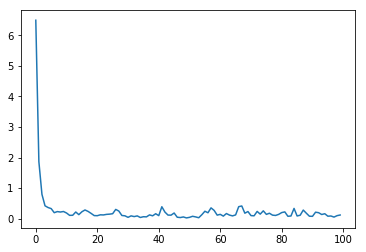

In [432]:
plt.plot(loss0["train"])
plt.show()

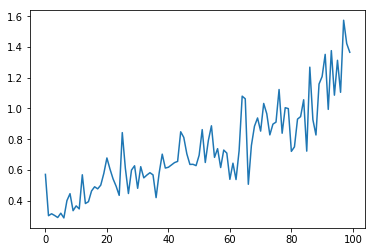

In [433]:
plt.plot(loss0["test"])
plt.show()

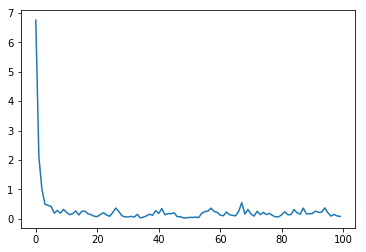

In [434]:
plt.plot(loss1["train"])
plt.show()

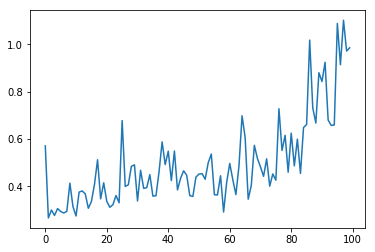

In [435]:
plt.plot(loss1["test"])
plt.show()

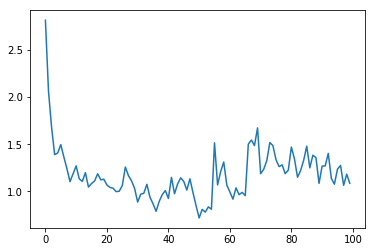

In [436]:
plt.plot(loss_class["train"])
plt.show()

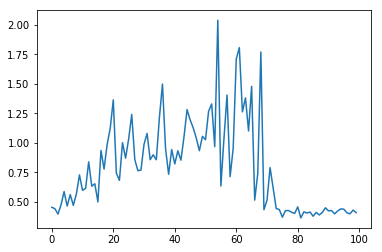

In [437]:
plt.plot(loss_class["test"])
plt.show()

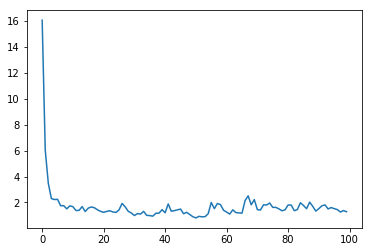

In [438]:
plt.plot(loss_tot["train"])
plt.show()

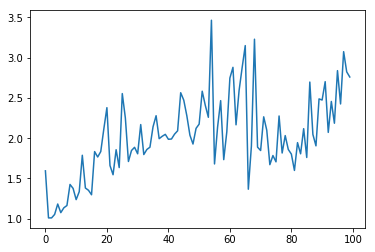

In [439]:
plt.plot(loss_tot["test"])
plt.show()

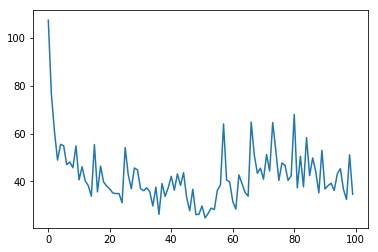

In [440]:
plt.plot(acc["train"])
plt.show()

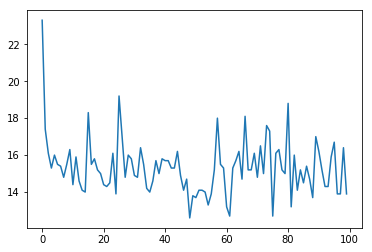

In [441]:
plt.plot(acc["test"])
plt.show()

In [387]:
try:
    del model
except NameError:
    pass
model = SiameseNet().to(device)
criterion = nn.CrossEntropyLoss().to(device)
mini_batch_size = 100
epochs = 250
eta = 0.01
loss0, loss1, loss_class, loss_tot, acc = train_siamese_losses(model, train_input, train_target, train_classes, test_input, test_classes, test_target, 
                         mini_batch_size, criterion, epochs, eta, optim="Adam", momentum = 0, nesterov = False, n=4)

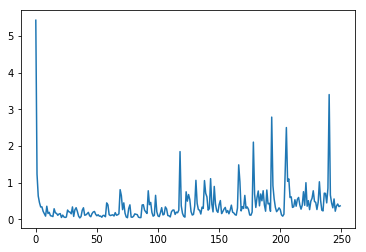

In [388]:
plt.plot(loss0["train"])
plt.show()

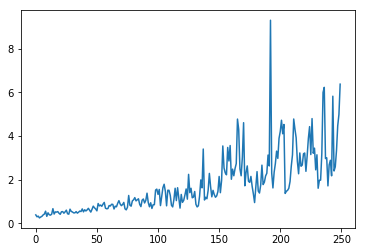

In [389]:
plt.plot(loss0["test"])
plt.show()

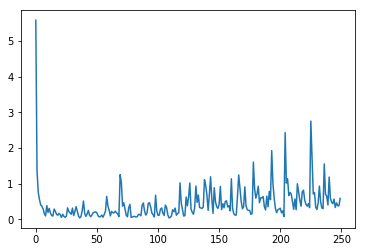

In [390]:
plt.plot(loss1["train"])
plt.show()

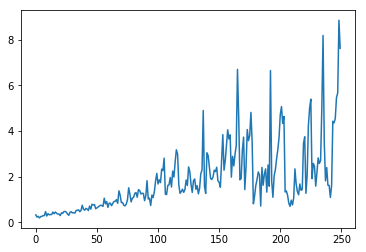

In [391]:
plt.plot(loss1["test"])
plt.show()

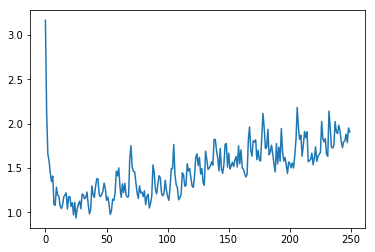

In [392]:
plt.plot(loss_class["train"])
plt.show()

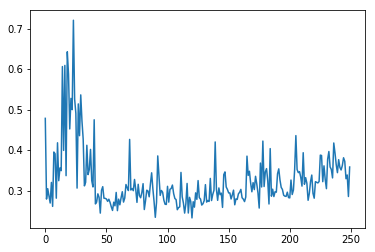

In [393]:
plt.plot(loss_class["test"])
plt.show()

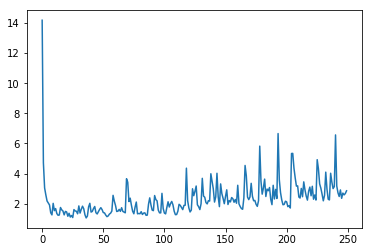

In [394]:
plt.plot(loss_tot["train"])
plt.show()

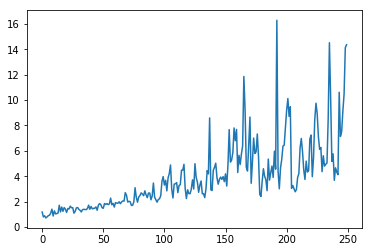

In [395]:
plt.plot(loss_tot["test"])
plt.show()

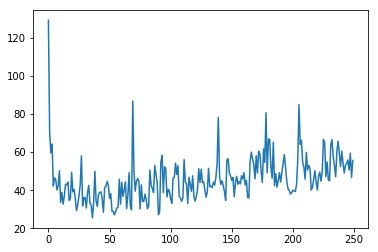

In [396]:
plt.plot(acc["train"])
plt.show()

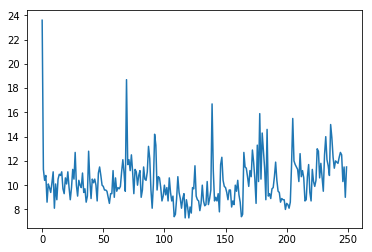

In [397]:
plt.plot(acc["test"])
plt.show()